<a href="https://www.kaggle.com/code/stephencox13/solving-a-classification-problem-with-knn?scriptVersionId=156543749" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### How to begin?
The offical [Titianic Tutorial](https://www.kaggle.com/alexisbcook/titanic-tutorial) provides an excellent starting point for novices to begin participating in Kaggle competitions. 

However, you will not score > 0.78 following that guide.

## You've scored ~0.78, now what?
Want to improve your score and break into the top 3% on the leaderboard? This tutorial is for you. 

Data science is a enormous field encompasing a plethora of technical knowledge and skills. This tutorial will walk you through the simplest possible approach to scoring > 0.8 on the Kaggle Titanic challenge. It will also direct you to important concepts to explore further. Helping to expand your understanding and guide the gradual development of your data science skillset. 

## First step, a little history...
An examination of the historical account of the Titanic ([Wikipedia](https://en.wikipedia.org/wiki/Titanic) and [BBC](https://www.bbc.com/news/magazine-17515305)) provides valuable understanding of the passenger data as it pertains to survival: 
1. A disproportionate number of men were left aboard because of a "women and children first" protocol for loading lifeboats.
2. First and second class passengers were most likely to reach the lifeboats. Third class passengers had to find their way through a maze of corridors and staircases to reach the boat deck.
3. Many lifeboats were launched only partially loaded.

Given the Titanic sank after colliding with an iceburg in the north Atlantic it's reasonable to expect anyone who didn't make it into a lifeboat was highly unlikely to survive due to cold exposure. Thus anyone not in a female-children-group **and** who did not get on a lifeboat before they were all launched was unlikely to survive.

### Let's get started!

In [1]:
# Import all packages that we'll work with 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import warnings

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Ignore deprecation warnings from sklearn
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# Load the training and test data into separate dataframes
train_data = pd.read_csv("../input/titanic/train.csv")
test_data = pd.read_csv("../input/titanic/test.csv")

# Use head() to look at the first 5 rows of the training data to understand what we will be working with 
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# describe() computes a summary of statistics for columns containing numeric data
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Age is missing 177 values
There are 891 rows in the training dataset. Using describe() we see the training dataset contains only 714 values for Age. From our historical analysis we know that women and children were preferentially loaded on to lifeboats. Therefore we will need a way to identify children. This presents a challenge due to the large amount of missing age data. We will return to this later...

## Exploratory Data Analysis (EDA)
We know from historical accounts that women and children were preferrentially loaded on to lifeboats. Let's use Seaborn to explore the relationship between gender and survival in our training dataset. 

For more information check out the tutorial: [Plotting with categorical data using Seaborn](https://seaborn.pydata.org/tutorial/categorical.html)

## EDA: Gender

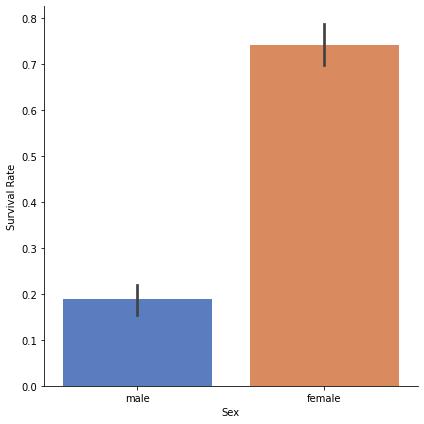

In [4]:
# Seaborn is imported as sns
gender_analysis = sns.catplot(x="Sex",y="Survived",data=train_data, kind="bar", height = 6, palette = "muted")
gender_analysis = gender_analysis.set_ylabels("Survival Rate")

The above bar chart confirms females were far more likely to survive. Next, let's see if passenger class impacted on survival for males and females...

## EDA: Passenger Class

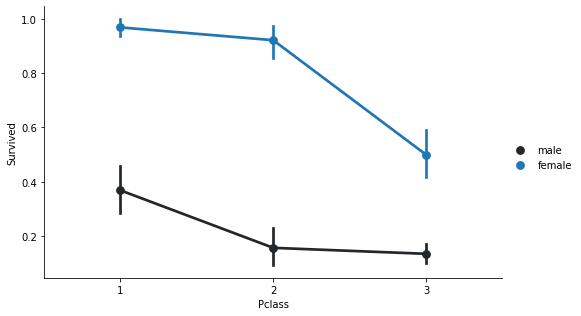

In [5]:
gender_pclass = sns.FacetGrid(train_data, height=4.5, aspect=1.6)
gender_pclass.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', order=None, hue_order=None )
gender_pclass.add_legend();

Wow! There's a significantly lower survival rate for females traveling 3rd class. This confirms the historical account that first and second class passengers were most likely to reach the lifeboats, which were hastely launched partially loaded with people. Finally, while continuing to ignore the missing age values for the moment let's explore how age correlate with survival... 

## EDA: Age

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


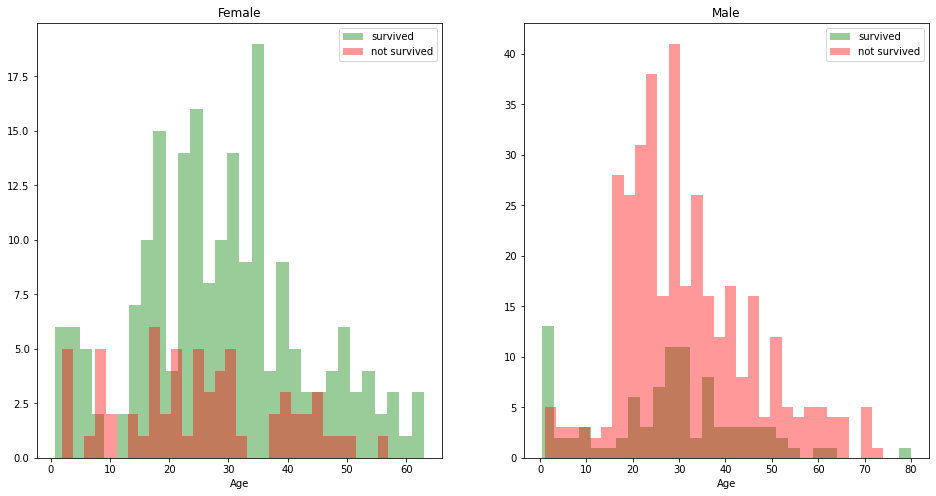

In [6]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 8))
women = train_data[train_data['Sex']=='female']
men = train_data[train_data['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=30, label = survived, ax = axes[0], kde =False, color="green")
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=30, label = not_survived, ax = axes[0], kde =False, color="red")
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=30, label = survived, ax = axes[1], kde = False, color="green")
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=30, label = not_survived, ax = axes[1], kde = False, color="red")
ax.legend()
title_male = ax.set_title('Male')

What's most noticable in the above charts is the relatively large proportion of very young males that survived. Now we have a simple hypothesis to guide our feature engineering efforts: female-children-groups travelling in 1st and 2nd class are by far the most likely passengers to survive. But with so much missing Age data how do we reliably detect boys? **The simple answer is to rely on the titles within passenger names as a proxy**. Specifically "Master", [a form of address used for boys](https://en.wikipedia.org/wiki/Master_(form_of_address). 

## Feature Engineering (FE)
A key step in preparing data to train ML models is One-Hot Encoding. Many machine learning algorithms cannot operate on categorical data such as Sex (female/male) directly. This means that categorical data must be converted to a numerical form. Here is a complete [one-hot encoding tutorial](https://towardsdatascience.com/what-is-one-hot-encoding-and-how-to-use-pandas-get-dummies-function-922eb9bd4970) for beginners, including how to use Pandas get_dummies function.

## FE: Gender

In [7]:
# Gender one hot encoding using dummies
train_data['Gender'] = pd.get_dummies(train_data['Sex'], drop_first=True)
test_data['Gender'] = pd.get_dummies(test_data['Sex'], drop_first=True)

# Drop the Sex, Embarked, and Fare columns as we will not build any further features using this data
train_data.drop(columns=['Sex', 'Embarked', 'Fare'], inplace=True)
test_data.drop(columns=['Sex', 'Embarked', 'Fare'], inplace=True)

## FE: Passengers Travelling in a Group (InGroup)

In [8]:
# Concatenate the train and test data together into a complete dataset for efficient feature engineering
_train = pd.read_csv("../input/titanic/train.csv")
_test = pd.read_csv("../input/titanic/test.csv")
dataset = pd.concat([_train, _test], sort=True, ignore_index=True)

# Note how many rows are in the training dataset. We'll use this later to easily add features created 
# in the concatenated dataset into the separate train and test datasets
train_len = len(train_data)

In [9]:
# Identify groups of passengers who traveled together (based on surname, passenger class, ticket number, and embarked) 
# and allocate each passenger in a particular group with the same GroupId

# Extract surname from Name
surname = dataset['Name'].apply(lambda x: x[:x.find(',')])

# Remove the last digit from ticket numbers as these are different for every passenger
ticket = dataset['Ticket'].apply(lambda x: x[:-1])

# Create a new field called PassengerGroup, which combines surname, passenger class, ticket number, and embarked
dataset['PassengerGroup'] = (surname.astype(str) + '-' + dataset['Pclass'].astype(str) + '-'
           + ticket.astype(str) + '-' + dataset['Embarked'].astype(str))

# Function to generate GroupIDs for each PassengerGroup. If there is only 1 PassengerId in the group then GroupId = 0, 
# meaning these are passengers who are not travelling in a group
def PassengerGroup_labeler(group):
    group_elements = dataset.loc[dataset['PassengerGroup'] == group, 'PassengerId']
    if len(group_elements) == 1:
        return 0
    else:
        return group_elements.min()

# Pass PassengerGroup through the above function to add GroupId to each passenger record    
dataset['GroupId'] = dataset['PassengerGroup'].apply(PassengerGroup_labeler)

# Drop PassengerGroup as no longer needed
dataset.drop(columns='PassengerGroup', inplace=True)

In [10]:
# InGroup is 1 for passengers with a GroupId otherwise 0
dataset['InGroup'] = (dataset['GroupId'] > 0).astype(int)

# Add InGroup to the train and test datasets using train_len
train_data['InGroup'] = dataset.iloc[:train_len, -1]
test_data['InGroup'] = dataset.iloc[train_len:, -1].reset_index(drop=True)

## FE: Passengers in a Female-Child-Group (InFCG)

In [11]:
# Female-child-groups are groups of passengers traveling together whose members are either females or boys 
# (i.e. males with the title of Master in their name). InFCG is 1 if the passenger is in a female-child-group, otherwise 0

# Extract title from passenger name
dataset['Title'] = dataset['Name'].apply(lambda x: x[x.find(', ') + 2:x.find('.')])

# Create a mask to account only for females or boys in groups
mask = (dataset['GroupId'] != 0) & ((dataset['Title'] == 'Master') | (dataset['Sex'] == 'female'))

# Get the number of females and boys in each group, discard groups with only one member
fcg_groups = dataset.loc[mask, 'GroupId'].value_counts()
fcg_groups = fcg_groups[fcg_groups > 1]

# Update the mask to discard groups with only one female or boy
mask = mask & (dataset['GroupId'].isin(fcg_groups.index))

# Create the new feature using the updated mask
dataset['InFCG'] = 0
dataset.loc[mask, 'InFCG'] = 1

# Add to the train and test datasets
train_data['InFCG'] = dataset.iloc[:train_len, -1]
test_data['InFCG'] = dataset.iloc[train_len:, -1].reset_index(drop=True)

## FE: Passengers in a Female-Child-Group that all Survived (FCGSurvived)

In [12]:
# For a passenger in a female-child-group, FCGSurvived is equal to 1 if all members of that group survived, otherwise 0
dataset['FCGSurvived'] = dataset.loc[dataset['InFCG'] == 1].groupby('GroupId')['Survived'].transform(np.nanmean)

# np.nanmean returns NaN for groups without survival information in test dataset. Replace the NaN with 0
dataset.loc[dataset['FCGSurvived'].isna(), 'FCGSurvived'] = 0
dataset['FCGSurvived'] = dataset['FCGSurvived'].astype(int)

# Add to the train and test datasets
train_data['FCGSurvived'] = dataset.iloc[:train_len, -1]
test_data['FCGSurvived'] = dataset.iloc[train_len:, -1].reset_index(drop=True)

In [13]:
# Drop remaining columns that will not be used to train our model
train_data.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Age'], inplace=True)
test_data.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Age'], inplace=True)

In [14]:
# View the features that will be used to train our model
train_data.head()

,PassengerId,Survived,Pclass,Gender,InGroup,InFCG,FCGSurvived
0,1,0,3,1,0,0,0
1,2,1,1,0,1,0,0
2,3,1,3,0,0,0,0
3,4,1,1,0,1,0,0
4,5,0,3,1,0,0,0


## Create a Model Using KNeighborsClassifier

In [15]:
# Split the training set into samples and targets
X_train = train_data.drop(columns='Survived')
Y_train = train_data['Survived'].astype(int)

# Test set samples to predict
X_test = test_data

# Standard Scaler is our friend. It helps to boost the score
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
model = KNeighborsClassifier(leaf_size=3, weights='uniform', n_neighbors=19)
model.fit(X_train, Y_train)

# Prediction
pred = model.predict(X_test)

## Create a Model Using Decision Tree Classifier

In [17]:
from sklearn import tree
classifier = tree.DecisionTreeClassifier(criterion='gini',
                                         splitter='best',
                                         max_depth=3,
                                         random_state=42)
classifier.fit(X_train, Y_train)
pred2 = classifier.predict(X_test)

## Interpret the Decison Tree Model

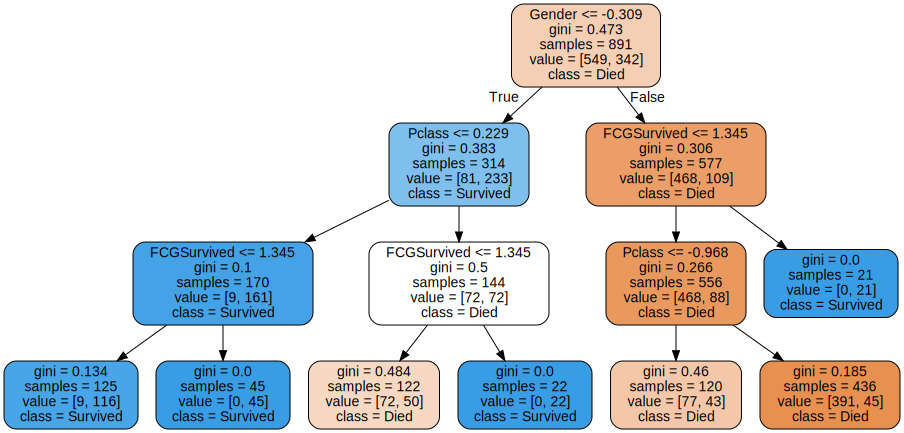

In [18]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(classifier, 
                           feature_names=['Survived', 'Pclass', 'Gender', 'InGroup', 'InFCG', 'FCGSurvived'], 
                           class_names=['Died', 'Survived'], 
                           filled=True, 
                           rounded=True,
                           proportion=False)
graphviz.Source(dot_data)

In the decision tree model (max_depth=3) all males who are not in a female-child-group that survived are expected to die. For females Pclass comes into play before membership in a female-child-group is considered.

## Generate a Submission to the Titanic Kaggle Competition

In [19]:
# Generate .csv submission file from KNeighborsClassifier for Kaggle
submission_df = pd.DataFrame({'PassengerId': _test['PassengerId'], 'Survived': pred})
submission_df.to_csv("submission.csv", index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


## Where to from here? 
How to keep learning while further improving your score...

### More feature engineering
1. Devise a sophisticated method for estimating missing age data, bucket passengers into appropriate age groupings, and build new features
2. Some men did survive. Figure out how to find them. Hint: Pclass 1, husbands of women with young children, age > 75
3. Identify new types of passenger groups

### Compare model performance
Run features through many different types of models and compare them to find the most effective

### Hyperparameter tuning
Automate model parameter settings to generate most effective setting for the most effective model

### Feedback Welcome!
Please comment and upvote if you found this tutorial helpful.